### Данный ноутбук был написан чтобы обучить модель сегментации (Unet) для выделения сегмента в детектировоном участке фото, для дальнейшего выравнивания номерного знака автомобиля - This notebook was written to train a segmentation model (Unet) to select a segment in the detected area of the photo, for further alignment of the car license plate

# Importing libraries - Импорт библиотек

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5699c7c3149f6860cdab87685cf1158f0e51639cf48ee072a27ce0ea42e134c4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=68a9aca4d1f21ad9206e073534c8ccba2049194816db666e86d9457a1da932c1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [2]:
!pip install --upgrade tqdm

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.transform import resize
import segmentation_models_pytorch as smp

import json
from glob import glob
import os
import cv2

from tqdm import tqdm_notebook
import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# We write functions and classes for preprocessing and training the model - Прописываем функции и классы для предобработки и обучения модели

In [4]:
def creatDataFrame(data: list, path: str) -> pd.DataFrame:
    data_columns = {
    'fileName': [],
    'rle_mask': [],
    'class': []
    }

    for elem in tqdm_notebook(data['annotations']):
        img = [i['file_name'] for i in data['images'] if i['id'] == elem['image_id']][0]
        img = [path + "/" + i['file_name'] for i in data['images'] if i['id'] == elem['image_id']][0]
        data_columns['fileName'].append(img)
        data_columns['rle_mask'].append(' '.join(map(lambda x: str(int(round(x))), elem['segmentation'][0])))
        data_columns['class'].append(elem['category_id'])
    return pd.DataFrame(data_columns)

In [5]:
def rle_decode(coordinates: str, image_shape=(640, 640)) -> np.ndarray:
    points = []
    dt = coordinates.split()
    for i in range(0, len(dt), 2):
        points.append((int(dt[i]), int(dt[i + 1])))
    mask = np.zeros(image_shape, dtype=np.uint8)
    for coord in points:
        mask[coord[1] - 1, coord[0] - 1] = 1
    for i in range(len(points) - 1):
        cv2.line(mask, points[i], points[i + 1], (1, 1, 1), 1)
    cv2.fillPoly(mask, [np.array(points)], (1, 1, 1))
    return mask

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        mask_rle = self.dataframe.iloc[idx, 1]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found.")
        image = Image.open(img_path).convert('RGB')
        mask = rle_decode(mask_rle, (image.height, image.width))
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [7]:
class Metrics:
    @staticmethod
    def f1_score(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        return f1.item()

    @staticmethod
    def precision(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        return precision.item()

    @staticmethod
    def recall(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        recall = tp / (tp + fn + 1e-6)
        return recall.item()

    @staticmethod
    def accuracy(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        correct = (y_true == y_pred).float().sum()
        accuracy = correct / y_true.numel()
        return accuracy.item()

# Data analysis - Анализ данных

In [8]:
with open('/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_1 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train')

with open('/kaggle/input/car-number-segment/misha_segm/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_2 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/misha_segm/train')
    
with open('/kaggle/input/car-number-segment/sasha/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_3 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/sasha/train')

with open('/kaggle/input/car-number-segment/simon/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_4 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/simon/train')

/tmp/ipykernel_24/196596626.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for elem in tqdm_notebook(data['annotations']):


  0%|          | 0/568 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

In [9]:
data_1

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/car_numbers.v...,8 49 158 40 158 10 6 18 8 49,1
1,/kaggle/input/car-number-segment/car_numbers.v...,8 52 224 52 226 11 8 11 8 52,1
2,/kaggle/input/car-number-segment/car_numbers.v...,12 139 287 79 282 11 4 74 12 139,1
3,/kaggle/input/car-number-segment/car_numbers.v...,6 57 222 111 226 63 11 7 6 57,1
4,/kaggle/input/car-number-segment/car_numbers.v...,106 13 16 8 10 27 102 34 106 13,1
...,...,...,...
563,/kaggle/input/car-number-segment/car_numbers.v...,13 65 309 62 310 7 12 11 13 65,1
564,/kaggle/input/car-number-segment/car_numbers.v...,194 7 11 36 5 96 189 62 194 7,1
565,/kaggle/input/car-number-segment/car_numbers.v...,94 7 5 24 5 46 95 28 94 7,1
566,/kaggle/input/car-number-segment/car_numbers.v...,177 14 7 6 5 38 174 45 177 14,1


In [10]:
data_2

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/misha_segm/tr...,309 8 16 7 12 64 305 65 309 8,1
1,/kaggle/input/car-number-segment/misha_segm/tr...,10 45 137 46 135 11 8 5 10 45,1
2,/kaggle/input/car-number-segment/misha_segm/tr...,10 33 99 28 99 8 9 13 10 33,1
3,/kaggle/input/car-number-segment/misha_segm/tr...,7 72 255 62 258 6 7 17 7 72,1
4,/kaggle/input/car-number-segment/misha_segm/tr...,6 53 236 76 235 35 8 7 6 53,1
...,...,...,...
571,/kaggle/input/car-number-segment/misha_segm/tr...,10 37 143 33 142 8 9 12 10 37,1
572,/kaggle/input/car-number-segment/misha_segm/tr...,8 32 71 26 71 6 8 10 8 32,1
573,/kaggle/input/car-number-segment/misha_segm/tr...,9 76 334 67 331 2 8 12 9 76,1
574,/kaggle/input/car-number-segment/misha_segm/tr...,7 172 303 72 304 6 19 114 7 172,1


In [11]:
data_3

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/sasha/train/7...,7 11 10 32 137 32 135 9 7 10 7 11,1
1,/kaggle/input/car-number-segment/sasha/train/8...,170 71 178 33 24 9 15 43 170 71,1
2,/kaggle/input/car-number-segment/sasha/train/2...,8 40 10 79 147 48 146 47 144 8 8 40,1
3,/kaggle/input/car-number-segment/sasha/train/0...,145 34 146 7 8 6 8 33 145 34,1
4,/kaggle/input/car-number-segment/sasha/train/3...,150 3 8 65 23 90 164 30 150 3,1
...,...,...,...
660,/kaggle/input/car-number-segment/sasha/train/3...,8 60 192 44 183 4 1 19 8 60,1
661,/kaggle/input/car-number-segment/sasha/train/1...,6 25 6 38 62 18 62 6 6 25 6 25,1
662,/kaggle/input/car-number-segment/sasha/train/9...,7 48 206 69 209 29 7 5 7 48,1
663,/kaggle/input/car-number-segment/sasha/train/5...,7 6 10 31 95 47 92 22 7 6,1


In [12]:
data_4

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/simon/train/b...,197 32 9 6 8 41 195 68 197 32,1
1,/kaggle/input/car-number-segment/simon/train/a...,5 24 83 34 87 14 8 7 5 24,1
2,/kaggle/input/car-number-segment/simon/train/4...,15 89 179 56 174 1 11 37 15 89,1
3,/kaggle/input/car-number-segment/simon/train/b...,7 37 154 43 158 13 10 9 7 37,1
4,/kaggle/input/car-number-segment/simon/train/7...,17 82 216 59 209 11 7 39 17 82,1
...,...,...,...
561,/kaggle/input/car-number-segment/simon/train/a...,9 26 67 20 64 3 5 12 9 26,1
562,/kaggle/input/car-number-segment/simon/train/b...,9 71 197 45 195 9 8 36 9 71,1
563,/kaggle/input/car-number-segment/simon/train/5...,6 59 260 69 262 19 10 5 6 59,1
564,/kaggle/input/car-number-segment/simon/train/5...,2 87 225 162 237 87 16 0 2 87,1


In [13]:
data_global = pd.concat([data_1, data_2, data_3, data_4])
data_global

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/car_numbers.v...,8 49 158 40 158 10 6 18 8 49,1
1,/kaggle/input/car-number-segment/car_numbers.v...,8 52 224 52 226 11 8 11 8 52,1
2,/kaggle/input/car-number-segment/car_numbers.v...,12 139 287 79 282 11 4 74 12 139,1
3,/kaggle/input/car-number-segment/car_numbers.v...,6 57 222 111 226 63 11 7 6 57,1
4,/kaggle/input/car-number-segment/car_numbers.v...,106 13 16 8 10 27 102 34 106 13,1
...,...,...,...
561,/kaggle/input/car-number-segment/simon/train/a...,9 26 67 20 64 3 5 12 9 26,1
562,/kaggle/input/car-number-segment/simon/train/b...,9 71 197 45 195 9 8 36 9 71,1
563,/kaggle/input/car-number-segment/simon/train/5...,6 59 260 69 262 19 10 5 6 59,1
564,/kaggle/input/car-number-segment/simon/train/5...,2 87 225 162 237 87 16 0 2 87,1


# Divide into training and validation set - Разделим на тренировочную и валидационную выборку

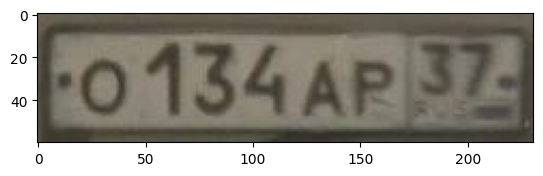

In [14]:
plt.imshow(cv2.imread(data_1.values[1][0]));

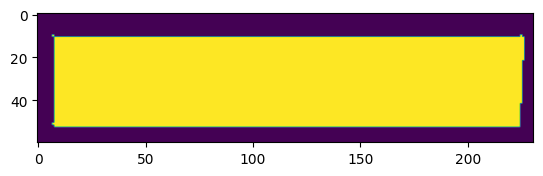

In [15]:
plt.imshow(rle_decode(coordinates=data_1.values[1][1], image_shape=cv2.imread(data_1.values[1][0]).shape[:2]));

In [16]:
image_transform = transforms.Compose([
    transforms.Resize((64, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda mask: resize(mask, (64, 192), order=0, preserve_range=True)),
    transforms.Lambda(lambda mask: torch.tensor(mask, dtype=torch.float32).unsqueeze(0))
])

In [17]:
train = data_global.iloc[512:, :]
valid = data_global.iloc[:512, :]


train_dataset = SegmentationDataset(dataframe=train, transform=image_transform, mask_transform=mask_transform)
valid_dataset = SegmentationDataset(dataframe=valid, transform=image_transform, mask_transform=mask_transform)

In [18]:
image, mask = train_dataset[0]
print(image.shape, mask.shape)

torch.Size([3, 64, 192]) torch.Size([1, 64, 192])


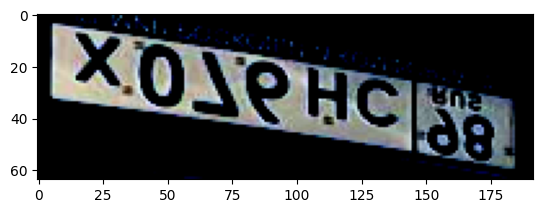

In [19]:
plt.imshow(image.permute(1, 2, 0).cpu().numpy());

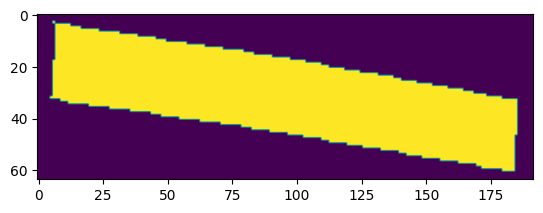

In [20]:
plt.imshow(mask.permute(1, 2, 0).cpu().numpy());

In [21]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


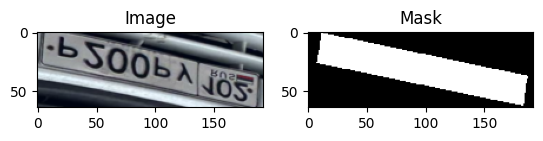

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


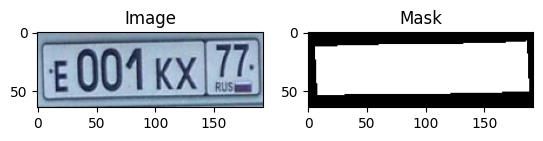

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


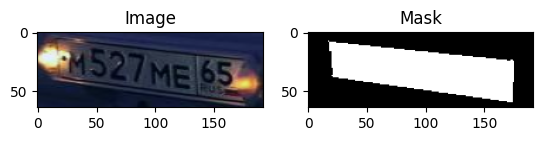

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


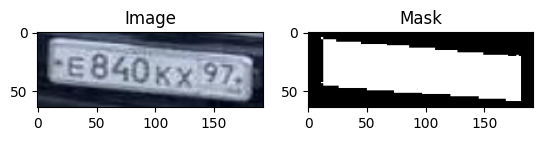

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


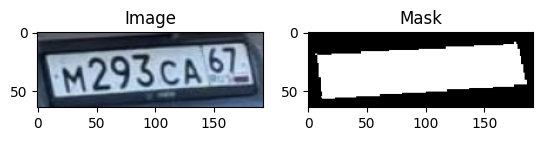

In [22]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

# Let’s initialize the model and write functions for training - С инициализируем модель и пропишим функции для обучения

In [23]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
loss_function = torch.nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 82.0MB/s]


In [24]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function
    model.train()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        batch_size = x_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_sigmoid = torch.sigmoid(output)
        metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
        metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
        metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
        metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'Loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res


def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            output_sigmoid = torch.sigmoid(output)
            metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
            metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
            metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
            metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res

In [25]:
epoches = 16

train_losses = []
metric_res_train = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': []
}

valid_losses = []
metric_res_valid = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': []
}

best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0
}
best_model_wts = 'model'
min_loss = 10**9

for epoch in range(epoches):
    losses_train_epoch, metric_res_train_epoch = train_one_epoch(train_dataloader, epoch, Metrics)
    train_losses.append(losses_train_epoch)
    for i in metric_res_train_epoch:
        metric_res_train[i].append(metric_res_train_epoch[i])
    
    losses_val_epoch, metric_res_val_epoch = validation_one_epoch(valid_dataloader, Metrics)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])
    
    if any([best_metrics[i] < metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch
    
    scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


/tmp/ipykernel_24/3135605544.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.1974304264838249
f1_score: 0.9312936893343862
precision: 0.9399736701194407
recall: 0.9256121008484451
accuracy: 0.9309227690220647


/tmp/ipykernel_24/3135605544.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.10714885772904381
f1_score: 0.9641609406098723
precision: 0.971637908834964
recall: 0.9572007241658866
accuracy: 0.9626814709044993
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.11234251356979115
f1_score: 0.9577617258777301
precision: 0.9586347722264944
recall: 0.9578900439919673
accuracy: 0.9565688919074038


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08979912428185344
f1_score: 0.9666521577164531
precision: 0.9726982652209699
recall: 0.9610906546004117
accuracy: 0.9652234916575253
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.09916647146913357
f1_score: 0.961250198316139
precision: 0.9618925751375371
recall: 0.9613487081891161
accuracy: 0.9600672794169018


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08821945547242649
f1_score: 0.9663057629950345
precision: 0.9608628326095641
recall: 0.972337884362787
accuracy: 0.9643871164880693
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.09250597117475713
f1_score: 0.962899404351454
precision: 0.9634405886749394
recall: 0.9629693295580689
accuracy: 0.9617727258099195


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08297963291988708
f1_score: 0.9681671252474189
precision: 0.971712336409837
recall: 0.9650547476485372
accuracy: 0.9666973948478699
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.08837743804970545
f1_score: 0.964145301076845
precision: 0.9648592360417688
recall: 0.9639710001707461
accuracy: 0.9630111637642738


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.085740660171723
f1_score: 0.9669726206921041
precision: 0.9669466568157077
recall: 0.9673991221934557
accuracy: 0.9653164725750685
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.08336955354905423
f1_score: 0.9657996573629907
precision: 0.9665790460343906
recall: 0.9654360014587337
accuracy: 0.9647564055839023


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08116530717234127
f1_score: 0.968404111918062
precision: 0.97447051666677
recall: 0.9627933748997748
accuracy: 0.9670111546292901
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.08115880874795935
f1_score: 0.9668757620193085
precision: 0.9677134445452011
recall: 0.9665039929086907
accuracy: 0.9657412234071884


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08410162405925803
f1_score: 0.967121013905853
precision: 0.9677021945826709
recall: 0.9668932501226664
accuracy: 0.9655080046504736
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.0769448817672105
f1_score: 0.9680516097536666
precision: 0.9687853001550008
recall: 0.9677322539858324
accuracy: 0.9670612617519295


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08346626127604395
f1_score: 0.9670889154076576
precision: 0.9709800751879811
recall: 0.9635709724389017
accuracy: 0.9655682453885674
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.07349311993509867
f1_score: 0.9693426598289354
precision: 0.9700677909008995
recall: 0.9690077301000819
accuracy: 0.9684017857299718


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.10299514987855218
f1_score: 0.959621973335743
precision: 0.9879887672141194
recall: 0.9331860425882041
accuracy: 0.9585654144175351
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.06353784179573922
f1_score: 0.9735037264040702
precision: 0.9750233005594324
recall: 0.97223857158752
accuracy: 0.9727283894407832


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08198118052678183
f1_score: 0.9683161657303572
precision: 0.9735305500216782
recall: 0.9634747188538313
accuracy: 0.9668480767868459
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.05936743913121398
f1_score: 0.9752477574463628
precision: 0.9759386743644329
recall: 0.9747461876559501
accuracy: 0.9745020239633446


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.0832641035085544
f1_score: 0.9681582036428154
precision: 0.9719614717178047
recall: 0.9647209951654077
accuracy: 0.9666336579248309
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.05632009841121785
f1_score: 0.9765193400303651
precision: 0.9772832030195481
recall: 0.9759129594233621
accuracy: 0.9758471771714768


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.0889043306815438
f1_score: 0.9667740999720991
precision: 0.9762441120110452
recall: 0.9578408882953227
accuracy: 0.9653519201092422
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.053908873605379416
f1_score: 0.977576825129877
precision: 0.9784240311854512
recall: 0.9768773853234942
accuracy: 0.9769272224850637


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08786171735846438
f1_score: 0.9670816715806723
precision: 0.970332277007401
recall: 0.9642135794274509
accuracy: 0.9654480810277164
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.05344763536944033
f1_score: 0.9777388165730401
precision: 0.9783346331125936
recall: 0.977281902499309
accuracy: 0.9770691911187532


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.08906479956931435
f1_score: 0.9667681064456701
precision: 0.9752557813189924
recall: 0.958772384095937
accuracy: 0.9652916775085032
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.053080746095169634
f1_score: 0.9779017602507939
precision: 0.9786178150038788
recall: 0.977315439246255
accuracy: 0.9772298105033059


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.0886082987417467
f1_score: 0.9669589707627892
precision: 0.9734406536445022
recall: 0.9609279031865299
accuracy: 0.965443470980972
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/466 [00:00<?, ?it/s]

Loss train: 0.05262988709389236
f1_score: 0.9780792740488078
precision: 0.9786401974598182
recall: 0.9776427881153309
accuracy: 0.9774388297232517


  0%|          | 0/128 [00:00<?, ?it/s]

Loss validation: 0.09044892466044985
f1_score: 0.966454912442714
precision: 0.9742400185205042
recall: 0.959167308639735
accuracy: 0.9649625020101666
-----------------------------------



# Learning outcomes - Результаты обучения

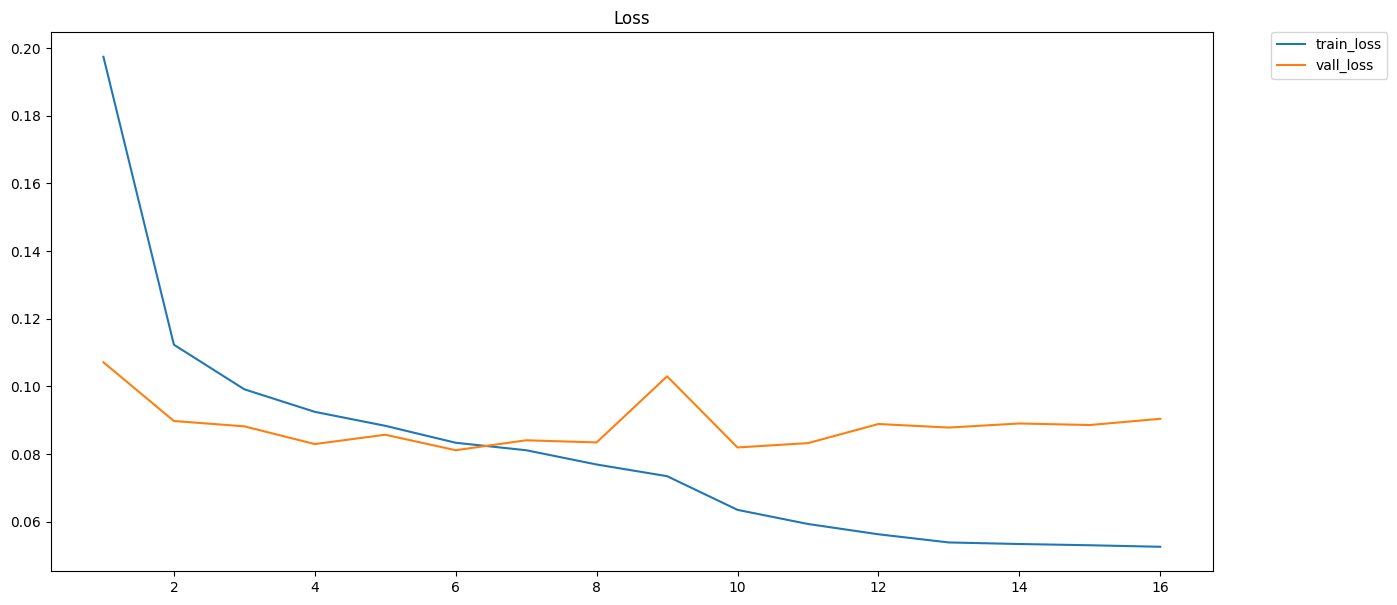

In [26]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

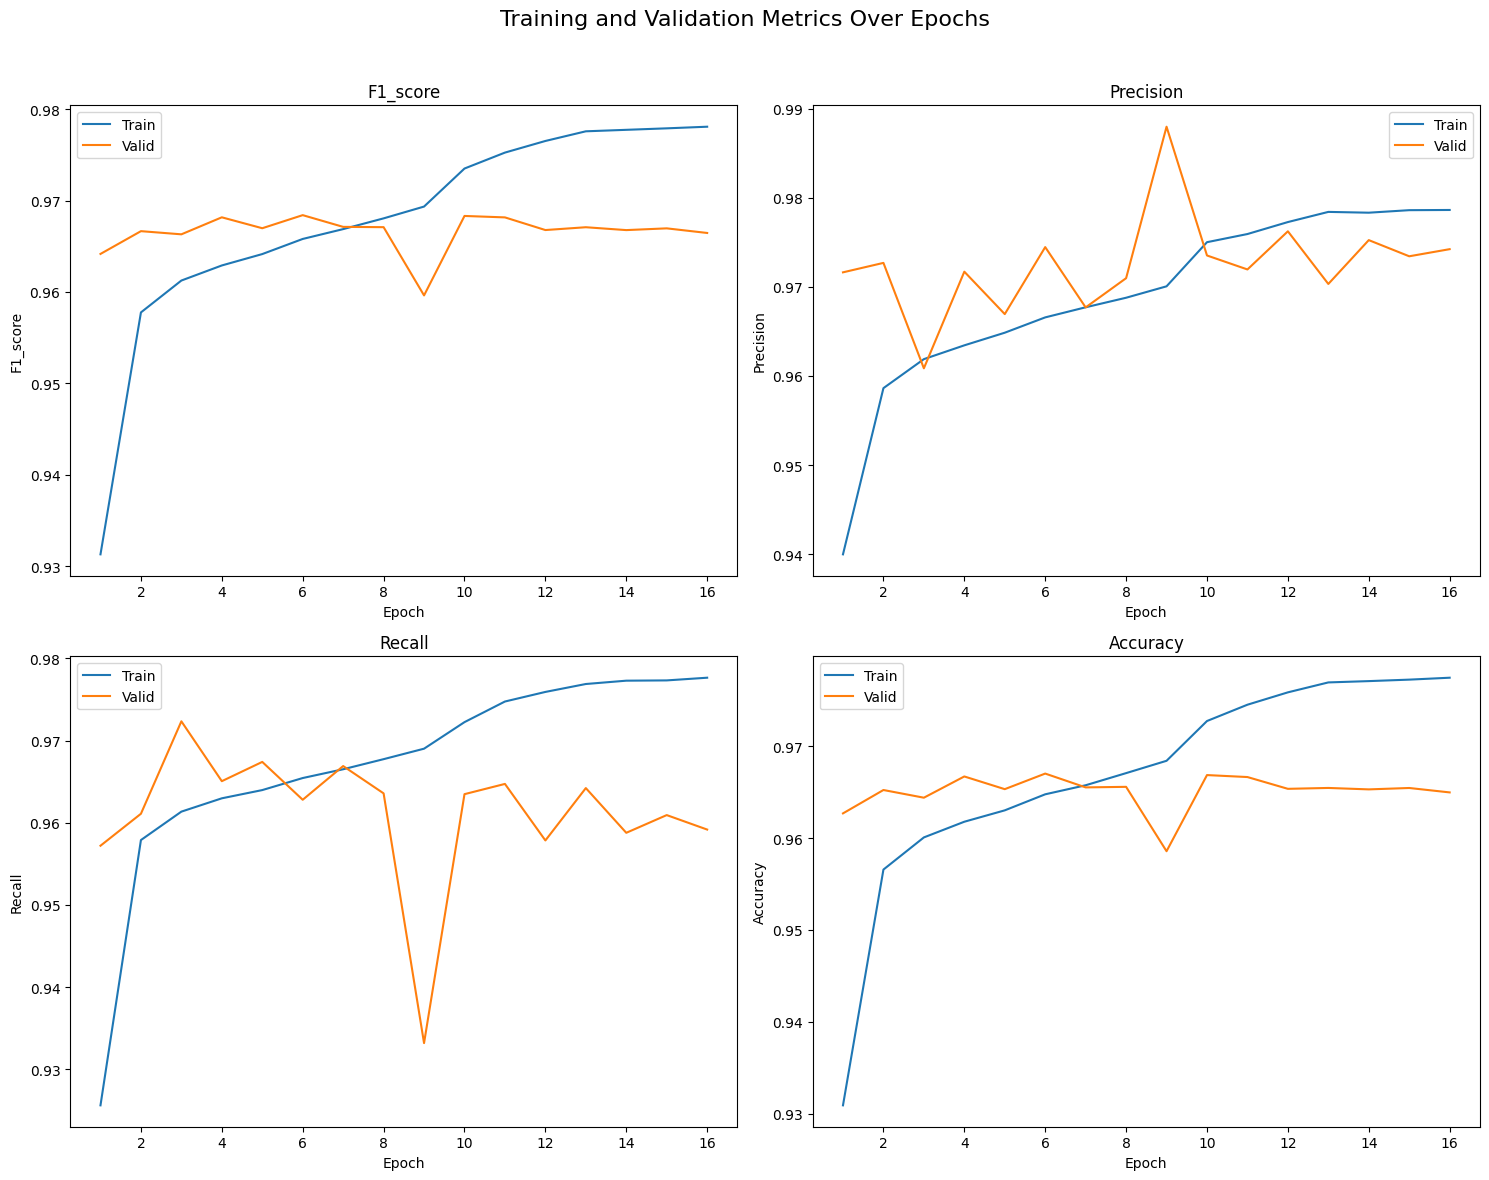

In [27]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')

best_metrics: {'f1_score': 0.968404111918062, 'precision': 0.97447051666677, 'recall': 0.9627933748997748, 'accuracy': 0.9670111546292901}
best_loss: 0.08116530717234127


# Visualizing the model's predictions - Визуализируем предсказания модели 

In [29]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


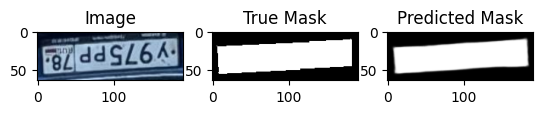

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


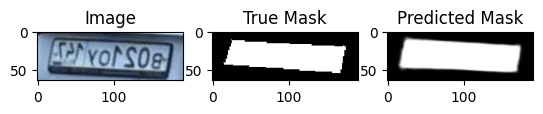

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


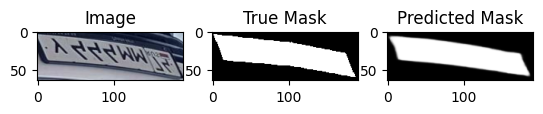

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


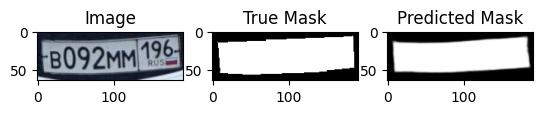

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


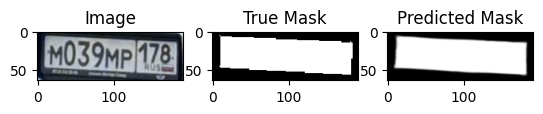

In [30]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    if batch_idx == 4:
        break

# Save model - Сохраняем модель 

In [31]:
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), 
    },
    'unet_model.pth'
)

In [32]:
torch.save(model.encoder.state_dict(), 'encoder_weights.pth')

In [33]:
# encoder = smp.encoders.get_encoder('resnet34', in_channels=3, pretrained='imagenet')
# encoder.load_state_dict(torch.load('/kaggle/working/encoder_weights.pth'))

In [34]:
model_load = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    classes=1,
    activation=None,
)

# Загрузка весов для encoder
encoder_state_dict = torch.load('/kaggle/working/encoder_weights.pth')
model_load.encoder.load_state_dict(encoder_state_dict)


checkpoint = torch.load('/kaggle/working/unet_model.pth')
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model_load = model_load.to(device)

Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


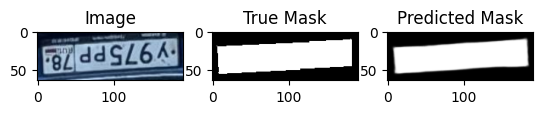

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


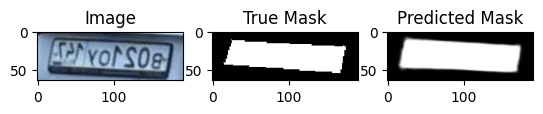

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


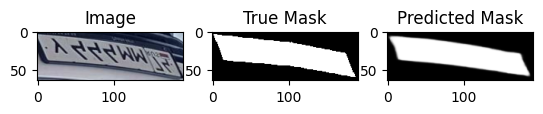

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


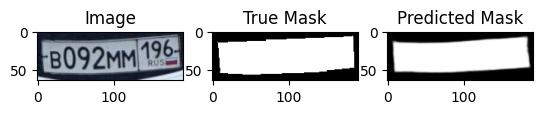

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


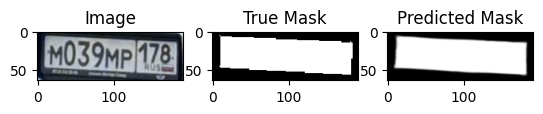

In [35]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    model_load.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model_load(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    if batch_idx == 4:
        break